# Описание проекта
Задача: выяснить поведение пользователей в мобильном приложении, изучив воронку продаж.
Затем исследовать результаты А/А/В эксперимента в результате изменения шрифта.

### Оглавление

### [Шаг 1. Готовим данные к анализу](#Шаг_1)
### [Шаг 2. Изучим и проверим данные](#Шаг_2)
 * [Сколько всего событий и пользователей в логе?](#Шаг_2_1)
 * [Полнота данных](#Шаг_2_2)
 * [Принадлежность пользователей по группам](#Шаг_2_3)

### [Шаг 3.  Изучим воронку событий](#Шаг_3)
* [События в логах](#Шаг_3_1)
* [Строим воронку](#Шаг_3_2)
* [Где теряем пользователей?](#Шаг_3_3)
* [Доля пользователей от первого события до оплаты](#Шаг_3_4)

### [Шаг 4.  Изучим результаты эксперимента](#Шаг_4)
* [Число пользователей и разница между А/А группами](#Шаг_4_1)
* [Самое популярное событие](#Шаг_4_2)
* [Сравниваем А/В группы](#Шаг_4_3)
* [Выводы](#Шаг_4_4)

### [Шаг 5.  Общий вывод](#Шаг_5)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import numpy as np
import math as mth
import warnings
warnings.filterwarnings("ignore")
from plotly import graph_objects as go

<a id = 'Шаг_1' > </a>
## Шаг 1. Подготовим данные

In [2]:
# выгрузим данные
data = pd.read_csv('logs_exp.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
# переименуем столбцы
data.columns = ['event_name', 'device_id','time_stamp', 'exp_id']
data

,event_name,device_id,time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
* event_name — название события;
* device_id — уникальный идентификатор пользователя;
* time_stamp — время события;
* exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [4]:
# добавим столбец даты и времени date_time к датафрейму с типом datetime.
data['date_time'] = pd.to_datetime(data['time_stamp'], unit = 's')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  int64         
 2   time_stamp  244126 non-null  int64         
 3   exp_id      244126 non-null  int64         
 4   date_time   244126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


In [5]:
# Добавим столбец даты
data['date'] = data['date_time'].dt.date
data

,event_name,device_id,time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [6]:
#проверим данные на дубликаты
data.duplicated().sum()

413

In [7]:
data[data.duplicated(keep = False)]

,event_name,device_id,time_stamp,exp_id,date_time,date
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2348,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3572,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
...,...,...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242362,CartScreenAppear,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242634,MainScreenAppear,4097782667445790512,1565206618,246,2019-08-07 19:36:58,2019-08-07


Дубликаты возникли вероятно из-за какой-то ошибки составления базы данных, либо запросы на сервер так же по ошибке поступали в некоторых случаях по два раза.
Поскольку процент дубликатов менее 1%, можно их беспрепятственно удалить.

In [8]:
data = data.drop_duplicates()
data

,event_name,device_id,time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Вывод 
Выгрузили данные, заменили название столбцов на более удобные, добавили столбец даты и времени, а так же столбец дат. Пропуски отсутствуют, дубликаты удалены. Данные готовы к анализу.

<a id = 'Шаг_2' > </a>
## Шаг 2. Изучим и проверим данные

<a id = 'Шаг_3_1'> </a>
#### Сколько всего событий и пользователей в логе?

In [9]:
# рассмотрим события в логах
events = data['event_name'].value_counts()
events

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [10]:
events.sum()

243713

Видим, что всего разных событий в логах 5.
* Главный экран
* Корзина
* Возможно страница со специальными предложениями
* Экран успешной покупки
* Обучение


Всего событий 243713

In [11]:
#рассмотрим число уникальных пользователей
users = data['device_id'].nunique()
print('Всего пользователей в логе: ',users)

Всего пользователей в логе:  7551


In [12]:
med_events_table = data.groupby('device_id').agg({'event_name':'count'})
med_events = int(med_events_table['event_name'].median())
print('В среднем на одного пользователя приходится {} событий'.format(med_events))

В среднем на одного пользователя приходится 20 событий


<a id = 'Шаг_2_2'> </a>
#### Данными за какой период вы располагаете?

In [13]:
data['date_time'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object

Первая дата - 25 июля 2019, последняя - 7 августа 2019.

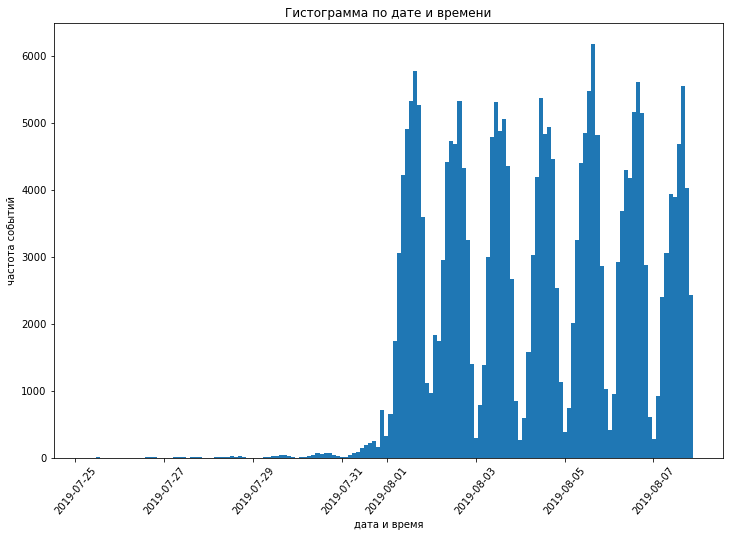

In [14]:
plt.figure(figsize = (12,8))
plt.hist(bins = 150, x=data["date_time"])
plt.xticks(rotation = 50)
plt.xlabel('дата и время')
plt.ylabel('частота событий')
plt.title('Гистограмма по дате и времени')
plt.show()

Судя по гистограмме, мы можем быть уверены в полноте данных только за август.
Отбросим данные за июль. Вероятно, данные, полученные за этот период - являются пробным запуском теста.

In [15]:
old_data = data.query('date_time < "2019-08-01"')
old_data

,event_name,device_id,time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,MainScreenAppear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,MainScreenAppear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,MainScreenAppear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31


Отбросив старые данные, потеряем 2030 событий.

In [16]:
old_data['device_id'].nunique()

1451

Старые данные содержат 924 уникальных пользователей.

In [17]:
#Число пользователей в актуальных данных
data = data.query('date_time >= "2019-08-01"')
data['device_id'].nunique()

7534

In [18]:
print('Разницу между числом уникальных пользователей в данных до чистки и после:', (users - data['device_id'].nunique()))

Разницу между числом уникальных пользователей в данных до чистки и после: 17


При этом видим, что в актуальных данных число уникальных пользователей уменьшилось всего на 17 после оптимизации. Вероятно в пилотном запуске принимали участие в основном те же покупатели.

<a id = 'Шаг_2_3' > </a>
Проверим, есть ли у нас  пользователи из всех трёх экспериментальных групп.

In [19]:
data.groupby('exp_id').agg({'device_id':'count'})

,device_id
exp_id,
246,79302
247,77022
248,84563


Получили близкие значения числа событий для всех трех групп.

#### Вывод

На этом этапе были изучены данные.
Первоначально в логе было 243713 событий и 7551 пользователей. Среднестатистически за все время исследования на одного пользователя приходится 20 событий.
Так же был найден период времени, которым мы располагаем на самом деле, у нас имеются данные, начиная с 25 июля, однако судя по построенному графику гистограммы, данные за июль вероятнее всего являются пробным запуском тестирования, поэтому мы исключаем их из анализа. При этом после удаления, число событий сократилось на 2030, однако число уникальных пользователей уменьшилось всего на 17.
Таким образом в нашем распоряжении остались только данные за август.

<a id = 'Шаг_3' > </a>
## Шаг 3. Изучим воронку событий

In [20]:
# События в логах
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Как уже было сказано выше разных событий в логах 5. 

* Главный экран
* Возможно страница со специальными предложениями
* Корзина
* Экран успешной покупки
* Обучение

##### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [21]:
data_grouped = data.groupby(['event_name','exp_id']).agg({'device_id':'nunique'}).sort_values(by = 'device_id', ascending = False).reset_index()
data_grouped

,event_name,exp_id,device_id
0,MainScreenAppear,248,2493
1,MainScreenAppear,247,2476
2,MainScreenAppear,246,2450
3,OffersScreenAppear,246,1542
4,OffersScreenAppear,248,1531
5,OffersScreenAppear,247,1520
6,CartScreenAppear,246,1266
7,CartScreenAppear,247,1238
8,CartScreenAppear,248,1230
9,PaymentScreenSuccessful,246,1200


Посчитаем долю пользователей хотя бы раз совершавших событие.

In [22]:
# таблица с общим числом пользователей
data_event = data.groupby('exp_id')['device_id'].nunique().reset_index()
data_event.columns = ['exp_id', 'overall_unique']
data_event

,exp_id,overall_unique
0,246,2484
1,247,2513
2,248,2537


In [23]:
#Объеденим таблицы 
final_data = data_grouped.merge(data_event, on = 'exp_id', how = 'outer')
final_data = final_data.set_index('event_name')
final_data.columns = ['exp_id', 'device_count', 'overall_unique']
final_data

,exp_id,device_count,overall_unique
event_name,,,
MainScreenAppear,248,2493,2537
OffersScreenAppear,248,1531,2537
CartScreenAppear,248,1230,2537
PaymentScreenSuccessful,248,1181,2537
Tutorial,248,279,2537
MainScreenAppear,247,2476,2513
OffersScreenAppear,247,1520,2513
CartScreenAppear,247,1238,2513
PaymentScreenSuccessful,247,1158,2513


In [24]:
# Добавим долю пользователей, хоть раз совершивших событие
final_data['ratio_for_users'] = final_data['device_count'] / final_data['overall_unique']
data_for_analysis = final_data.groupby(['exp_id','event_name','device_count']).agg({'ratio_for_users':'mean'}).sort_values(by = ['exp_id','device_count'], ascending = [True,False]).reset_index().set_index(['exp_id','event_name'])
data_for_analysis

device_count  ratio_for_users
exp_id event_name                                            
246    MainScreenAppear                 2450         0.986312
       OffersScreenAppear               1542         0.620773
       CartScreenAppear                 1266         0.509662
       PaymentScreenSuccessful          1200         0.483092
       Tutorial                          278         0.111916
247    MainScreenAppear                 2476         0.985277
       OffersScreenAppear               1520         0.604855
       CartScreenAppear                 1238         0.492638
       PaymentScreenSuccessful          1158         0.460804
       Tutorial                          283         0.112614
248    MainScreenAppear                 2493         0.982657
       OffersScreenAppear               1531         0.603469
       CartScreenAppear                 1230         0.484825
       PaymentScreenSuccessful          1181         0.465510
       Tutorial                          279         0.109972

Критерием успешности определим событие завершенной покупки. Доля пользователей хотя бы раз совершивших покупку от общего числа уникальных пользователей в этой группе в группе 246 выше, чем в 247 и 248.

Так же из этой таблицы логично вытекает последовательность действий: 
MainScreenAppear(главный экран) -> OffersScreenAppear(специальные предложения) -> CartScreenAppear(корзина) -> PaymentScreenSuccessful(покупка совершена).
Таким образом из порядка выпадает tutorial, поскольку пользователям может потребоваться помощь на разных этапах просмотра сайта.

##### Построим воронку событий

In [25]:
# не будем учитывать в воронке tutorial
data_new = data.query('event_name != "Tutorial"')
data_new

,event_name,device_id,time_stamp,exp_id,date_time,date
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Каждая строка таблицы — пользователь. В столбцах — время первого срабатывания каждого события. Если события из категории не случалось, в его ячейке — NaT

<a id = 'Шаг_4_3' > </a>
Напишем функцию для расчета воронки для разных экспериментальных групп

In [26]:
def funnel(group):
    data_even = data_new.query('exp_id == @group')
    users = data_even.pivot_table(
        index='device_id', 
        columns='event_name', 
        values='date_time',
        aggfunc='min') 
    
    step_1 = ~users['MainScreenAppear'].isna()
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['OffersScreenAppear'])

    n_pageview = users[step_1].shape[0]
    n_offers = users[step_2].shape[0]
    n_cart = users[step_3].shape[0]
    n_payment = users[step_4].shape[0]
    if group == 246 or group == 247:
        print('Воронка для контрольной группы')
    else:
        print('Воронка для экспериментальной группы')
    print('Посетили главный экран:', n_pageview)
    print('Посетили страницу со специальными предложениями:', n_offers)
    print('Начали оформлять заказ:', n_cart)
    print('Оплатили:', n_payment)
    fig = go.Figure(go.Funnel(
    y = ["главный экран", "Страница со спец. предложениями", "Начали оформлять заказ", "Оплатили"],
    x = [n_pageview, n_offers, n_cart, n_payment], textinfo = 'percent previous+percent initial+value' ))
    fig.show("svg")

Воронка для контрольной группы
Посетили главный экран: 2450
Посетили страницу со специальными предложениями: 1411
Начали оформлять заказ: 584
Оплатили: 546


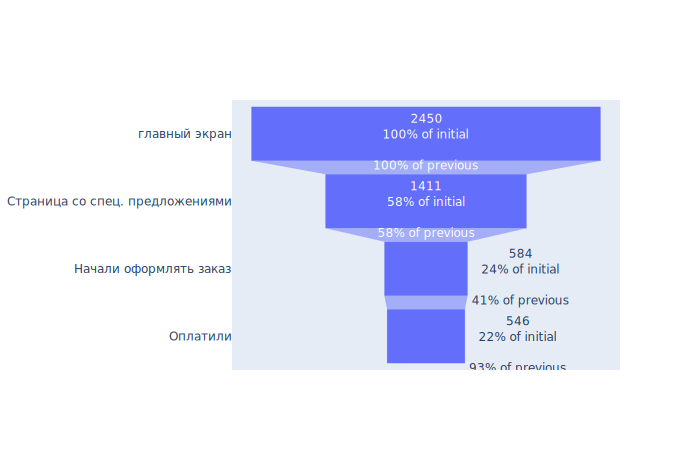

In [27]:
funnel(246)

Воронка для контрольной группы
Посетили главный экран: 2476
Посетили страницу со специальными предложениями: 1379
Начали оформлять заказ: 600
Оплатили: 563


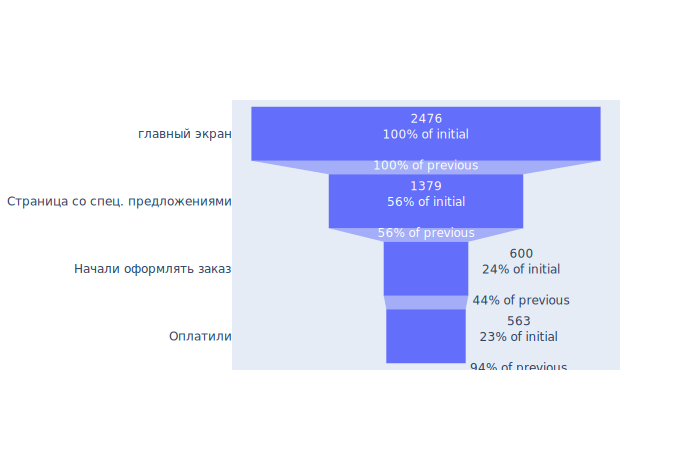

In [28]:
funnel(247)

Воронка для экспериментальной группы
Посетили главный экран: 2493
Посетили страницу со специальными предложениями: 1411
Начали оформлять заказ: 583
Оплатили: 556


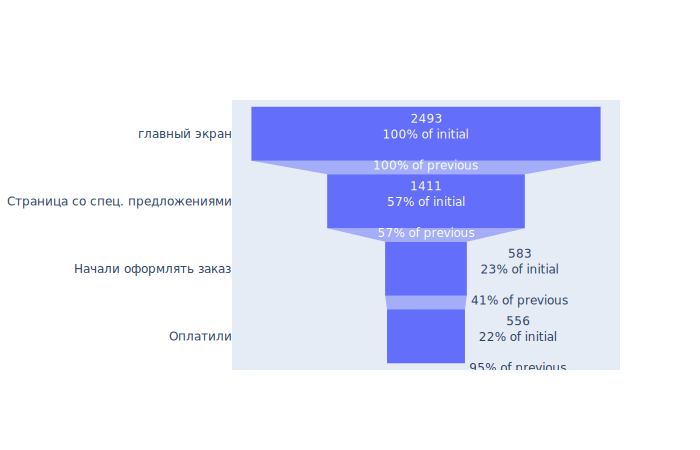

In [29]:
funnel(248)

Эти данные можно проинтерпретировать следующим образом: получили воронки с учетом последовательности событий. Из них следует, что после страницы со спец предложениями "отваливается" очень большое число пользователей, однако вероятно многие пользователи переходят к оформлению без посещения страницы со специальными предложениями, поэтому я считаю, корректнее построить простую продутовую воронку без учета последовательности событий.

In [30]:
data_for_analysis

device_count  ratio_for_users
exp_id event_name                                            
246    MainScreenAppear                 2450         0.986312
       OffersScreenAppear               1542         0.620773
       CartScreenAppear                 1266         0.509662
       PaymentScreenSuccessful          1200         0.483092
       Tutorial                          278         0.111916
247    MainScreenAppear                 2476         0.985277
       OffersScreenAppear               1520         0.604855
       CartScreenAppear                 1238         0.492638
       PaymentScreenSuccessful          1158         0.460804
       Tutorial                          283         0.112614
248    MainScreenAppear                 2493         0.982657
       OffersScreenAppear               1531         0.603469
       CartScreenAppear                 1230         0.484825
       PaymentScreenSuccessful          1181         0.465510
       Tutorial                          279         0.109972

In [31]:
#напишем функцию для построения простой воронки
def funnel_simple(group):
    data_funnel = data_for_analysis.reset_index().query('exp_id == @group')
    if group == 246 or group == 247:
            layout = go.Layout(
        title="Простая воронка для контрольной группы",
    
        yaxis=dict(
            title="число пользователей"
        ) ) 
    else: 
        layout = go.Layout(
        title="Простая воронка для экспериментальной группы",
    
        yaxis=dict(
            title="число пользователей"
        ) ) 
    x = ["главный экран", "Страница со спец. предложениями", "Начали оформлять заказ", "Оплатили"]
    y = data_funnel['device_count']
    fig = go.Figure(layout = layout ,data=[go.Bar(
            x=x, y=y,
            text=(data_funnel['ratio_for_users'].map('{:.2%}'.format)),
            textposition='auto'
        )])
    fig.show("svg")
    
    

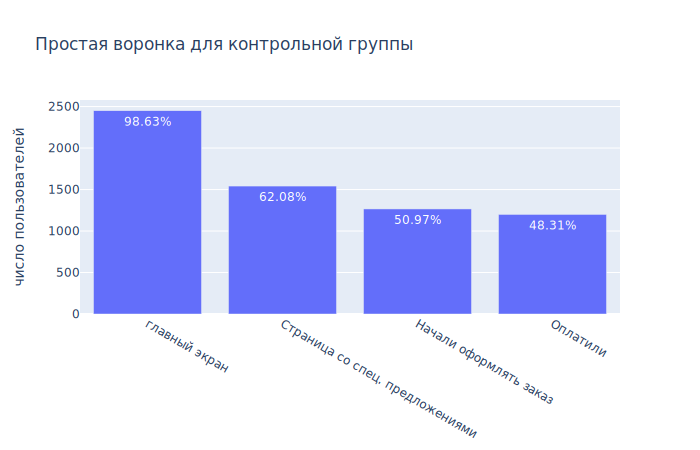

In [32]:
funnel_simple(246)

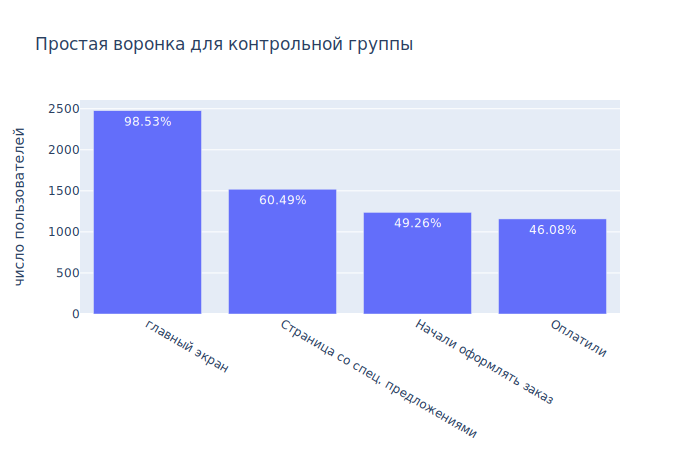

In [33]:
funnel_simple(247)

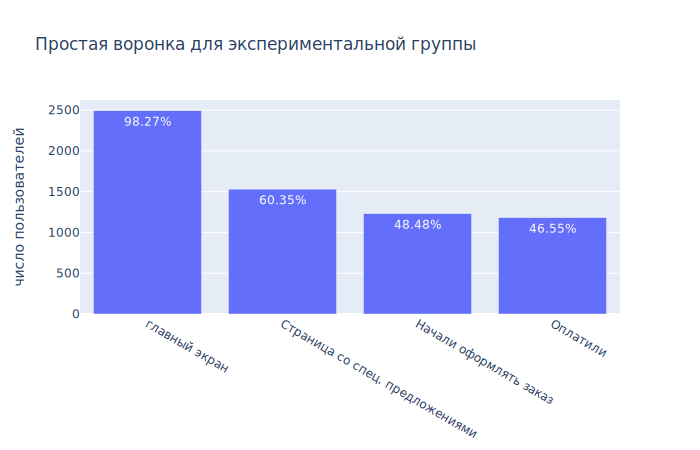

In [34]:
funnel_simple(248)

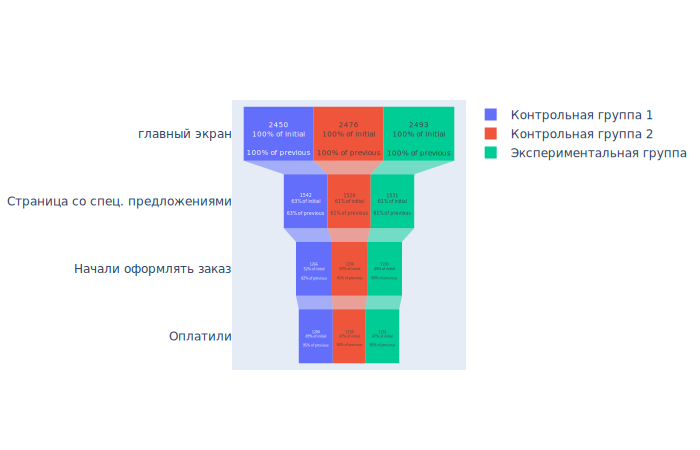

In [35]:
fig = go.Figure()
layout = go.Layout(
        title="Простая воронка для 3 различных групп",
    
        yaxis=dict(
            title="число пользователей"
        ) ) 
fig.add_trace(go.Funnel(
    name = 'Контрольная группа 1',
    y = ["главный экран", "Страница со спец. предложениями", "Начали оформлять заказ", "Оплатили"]
    ,
    x = data_for_analysis.reset_index().query('exp_id == 246')['device_count'],
    textinfo = 'percent previous+percent initial+value'))

fig.add_trace(go.Funnel(
    name = 'Контрольная группа 2',
    orientation = "h",
    y = ["главный экран", "Страница со спец. предложениями", "Начали оформлять заказ", "Оплатили"],
    x = data_for_analysis.reset_index().query('exp_id == 247')['device_count'],
    textposition = "inside",
    textinfo = 'percent previous+percent initial+value'))

fig.add_trace(go.Funnel(
    name = 'Экспериментальная группа',
    orientation = "h",
    y = ["главный экран", "Страница со спец. предложениями", "Начали оформлять заказ", "Оплатили"],
    x = data_for_analysis.reset_index().query('exp_id == 248')['device_count'],
    textposition = "inside",
    textinfo = 'percent previous+percent initial+value'))

fig.show("svg")

<a id = 'Шаг_3_3' > </a>
<a id = 'Шаг_3_4' > </a>
Стоит отметить, то на первом шаге воронки теряется небольшое количество пользователей, возможно из-за какой-то програмной ошибки.
Больше всего пользователей теряем после 1-го шага, то есть после посещения главного экрана.
От первого события до оплаты доходит 48.3% и 46.1% от всего числа уникальных пользователей в случае контрольных групп и 46.55% в случае экспериментальной группы.

#### Вывод

На данном этапе отсортировали события по частоте и предположили последовательность событий (Главный экран -> Страница со спец. предложениями -> Начали оформлять заказ -> Оплатили), так же предположили, что туториал не входит в стандартную воронку, поскольку люди переходят на него с разных этапов.
Так же определили, что воронка с учетом последовательности событий не подходит для анализа, из-за того, что многие пользователи переходят к оплате с разных этапов.
По простой продуктовой воронке определили, что больше всего пользователей теряется после перехода с главного на экрана.
До оплаты доходят менее 50% пользователей.
При этом разница между контрольными и экспериментальной группами не выглядит значительной, далее проверим статистическую значимость различий.

<a id = 'Шаг_4' ></a>
## Шаг 4. Изучим результаты эксперимента

<a id = 'Шаг_4_1'></a>
#### Число пользователей в каждой экспериментальной группе

In [36]:
data_event = data.groupby('exp_id')['device_id'].nunique().reset_index()
data_event.columns = ['exp_id', 'overall_unique']
data_event

,exp_id,overall_unique
0,246,2484
1,247,2513
2,248,2537


##### Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Проверим гипотезы для долей конверсии при переходе от события к событию.

H0 - разница между конверсиями от общего числа уникальных пользователей в событие MainScreenAppear отсутствует

H1 - конверсии в событие MainScreenAppear для двух контрольных групп отличаются

In [37]:
#избавимся от события tutorial
data_for_analysis = data_for_analysis.query('device_count > 300')
data_for_analysis = data_for_analysis.reset_index(level=[0,1])
data_for_analysis

,exp_id,event_name,device_count,ratio_for_users
0,246,MainScreenAppear,2450,0.986312
1,246,OffersScreenAppear,1542,0.620773
2,246,CartScreenAppear,1266,0.509662
3,246,PaymentScreenSuccessful,1200,0.483092
4,247,MainScreenAppear,2476,0.985277
5,247,OffersScreenAppear,1520,0.604855
6,247,CartScreenAppear,1238,0.492638
7,247,PaymentScreenSuccessful,1158,0.460804
8,248,MainScreenAppear,2493,0.982657
9,248,OffersScreenAppear,1531,0.603469


In [38]:
data_test = data_for_analysis.merge(data_event, on = 'exp_id')
data_test

,exp_id,event_name,device_count,ratio_for_users,overall_unique
0,246,MainScreenAppear,2450,0.986312,2484
1,246,OffersScreenAppear,1542,0.620773,2484
2,246,CartScreenAppear,1266,0.509662,2484
3,246,PaymentScreenSuccessful,1200,0.483092,2484
4,247,MainScreenAppear,2476,0.985277,2513
5,247,OffersScreenAppear,1520,0.604855,2513
6,247,CartScreenAppear,1238,0.492638,2513
7,247,PaymentScreenSuccessful,1158,0.460804,2513
8,248,MainScreenAppear,2493,0.982657,2537
9,248,OffersScreenAppear,1531,0.603469,2537


Сформулируем гипотезы перед проведением тестов.

H0 - разница между конверсиями от общего числа уникальных пользователей в различные события для проверяемых групп отсутствует

H1 - конверсии в различные события для двух проверяемых групп отличаются

In [39]:
data_test

,exp_id,event_name,device_count,ratio_for_users,overall_unique
0,246,MainScreenAppear,2450,0.986312,2484
1,246,OffersScreenAppear,1542,0.620773,2484
2,246,CartScreenAppear,1266,0.509662,2484
3,246,PaymentScreenSuccessful,1200,0.483092,2484
4,247,MainScreenAppear,2476,0.985277,2513
5,247,OffersScreenAppear,1520,0.604855,2513
6,247,CartScreenAppear,1238,0.492638,2513
7,247,PaymentScreenSuccessful,1158,0.460804,2513
8,248,MainScreenAppear,2493,0.982657,2537
9,248,OffersScreenAppear,1531,0.603469,2537


In [40]:
#Напишем функцию для расчета статистической значимости.
def stat(group1, group2, data):
    alpha = .05 / 16
    print('Проверим гипотезу об отличии долей между группами {} и {}'.format(group1,group2))
    print()
    for event in data['event_name'].unique():
        screen = np.array([data.query('exp_id == @group1 & event_name == @event')['device_count'].tolist(),
                  data.query('exp_id == @group2 & event_name == @event')['device_count'].tolist()])
        overall = np.array([data.query('exp_id == @group1 & event_name == @event')['overall_unique'].tolist(),
                  data.query('exp_id == @group2 & event_name == @event')['overall_unique'].tolist()])
        p1 = screen[0] / overall[0]
        p2 = screen[1] / overall[1]
        p_combined = (screen[0] + screen[1]) / (overall[0] + overall[1])
        difference = p1 - p2
        print('Событие', event)
        print(f'Доля 1 = {p1[0]:.7f}')
        print(f'Доля 2 = {p2[0]:.7f}')
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/overall[0] + 1/overall[1])) #кажется ошибка была тут 

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(f"p-value = {p_value[0]:.2f}")

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между конверсиями в события есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными") 
        print()    

In [41]:
stat(246,247, data_test)

Проверим гипотезу об отличии долей между группами 246 и 247

Событие MainScreenAppear
Доля 1 = 0.9863124
Доля 2 = 0.9852766
p-value = 0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие OffersScreenAppear
Доля 1 = 0.6207729
Доля 2 = 0.6048548
p-value = 0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие CartScreenAppear
Доля 1 = 0.5096618
Доля 2 = 0.4926383
p-value = 0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие PaymentScreenSuccessful
Доля 1 = 0.4830918
Доля 2 = 0.4608038
p-value = 0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



Гипотезу о равенстве долей не удалось отвергнуть. Статистические тесты не находят разницы между контрольными выборками.
Разбиение на группы вероятнее всего корректно.

Аналогично проверим контрольные группы с экспериментальной. Гипотезы также аналогичны.

In [42]:
# Группа 246 и 248
stat(246,248, data_test)

Проверим гипотезу об отличии долей между группами 246 и 248

Событие MainScreenAppear
Доля 1 = 0.9863124
Доля 2 = 0.9826567
p-value = 0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие OffersScreenAppear
Доля 1 = 0.6207729
Доля 2 = 0.6034687
p-value = 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие CartScreenAppear
Доля 1 = 0.5096618
Доля 2 = 0.4848246
p-value = 0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие PaymentScreenSuccessful
Доля 1 = 0.4830918
Доля 2 = 0.4655104
p-value = 0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



Гипотезы о равенстве долей контрольной группы 246 и экспериментальной 248 групп нет оснований отвергать на всех этапах взаимодействия пользователя с сайтом.

In [43]:
#Группа 247 и 248
stat(247,248, data_test)

Проверим гипотезу об отличии долей между группами 247 и 248

Событие MainScreenAppear
Доля 1 = 0.9852766
Доля 2 = 0.9826567
p-value = 0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие OffersScreenAppear
Доля 1 = 0.6048548
Доля 2 = 0.6034687
p-value = 0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие CartScreenAppear
Доля 1 = 0.4926383
Доля 2 = 0.4848246
p-value = 0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие PaymentScreenSuccessful
Доля 1 = 0.4608038
Доля 2 = 0.4655104
p-value = 0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



Аналогично гипотезы о равенстве долей контрольной группы 247 и экспериментальной 248 групп нет оснований отвергать на всех этапах взаимодействия пользователя с сайтом.

Теперь сравним результаты с объединенной контрольной группой

In [44]:
# Создадим копию исходного датасета
data_copy = data_new.copy()
data_copy = data_copy.replace ({246 :'246 + 247', 247:'246 + 247'})
data_copy

,event_name,device_id,time_stamp,exp_id,date_time,date
2829,MainScreenAppear,3737462046622621720,1564618080,246 + 247,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246 + 247,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246 + 247,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,246 + 247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,246 + 247,2019-08-01 00:10:15,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,246 + 247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246 + 247,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246 + 247,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246 + 247,2019-08-07 21:14:58,2019-08-07


In [45]:
data_for_test = data_copy.groupby(['exp_id','event_name']).agg({'device_id':'nunique'}).sort_values(by = ['exp_id','device_id'], ascending = [True,False]).reset_index().set_index(['exp_id','event_name'])
data_for_test = data_for_test.reset_index(level=[0,1])
data_for_test

,exp_id,event_name,device_id
0,248,MainScreenAppear,2493
1,248,OffersScreenAppear,1531
2,248,CartScreenAppear,1230
3,248,PaymentScreenSuccessful,1181
4,246 + 247,MainScreenAppear,4926
5,246 + 247,OffersScreenAppear,3062
6,246 + 247,CartScreenAppear,2504
7,246 + 247,PaymentScreenSuccessful,2358


In [46]:
data_event_copy = data_copy.groupby('exp_id')['device_id'].nunique().reset_index()
data_event_copy.columns = ['exp_id', 'overall_unique']
data_event_copy

,exp_id,overall_unique
0,248,2535
1,246 + 247,4995


In [47]:
data_test_copy = data_for_test.merge(data_event_copy, on = 'exp_id')
data_test_copy.columns = ['exp_id', 'event_name','device_count','overall_unique']
data_test_copy

,exp_id,event_name,device_count,overall_unique
0,248,MainScreenAppear,2493,2535
1,248,OffersScreenAppear,1531,2535
2,248,CartScreenAppear,1230,2535
3,248,PaymentScreenSuccessful,1181,2535
4,246 + 247,MainScreenAppear,4926,4995
5,246 + 247,OffersScreenAppear,3062,4995
6,246 + 247,CartScreenAppear,2504,4995
7,246 + 247,PaymentScreenSuccessful,2358,4995


In [48]:
stat("246 + 247", 248 , data_test_copy)

Проверим гипотезу об отличии долей между группами 246 + 247 и 248

Событие MainScreenAppear
Доля 1 = 0.9861862
Доля 2 = 0.9834320
p-value = 0.35
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие OffersScreenAppear
Доля 1 = 0.6130130
Доля 2 = 0.6039448
p-value = 0.45
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие CartScreenAppear
Доля 1 = 0.5013013
Доля 2 = 0.4852071
p-value = 0.19
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Событие PaymentScreenSuccessful
Доля 1 = 0.4720721
Доля 2 = 0.4658777
p-value = 0.61
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



При сравнении экспериментальной и объединенных контрольных выборок не получили статистически значимых различий долей.

<a id = 'Шаг_4_4' > </a> 
#### Вывод

Судя по полученным результатам z-тестов, мы не смогли ни в одном из случаев отвергнуть гипотезы о равенстве долей. 
По этим данным, вероятнее всего, изменения шрифта никак не влияет на посетителей магазина. 
Однако, учитывая количество гипотез(16), вероятность получения ложного результата слишком высока, поэтому необходимо снизить вероятность ложнопозитивного результата. Для корректировки применим поправку Бонферрони: поделим все уровни значимости на 16.

После изменения уровня значимости, все результаты остаются релевантны.
Вероятно, действительно, нет оснований полагать, что изменение шрифта как-то меняет поведение пользователей.

<a id = 'Шаг_5'> </a>
## Шаг 5. Общий вывод.

На первом шаге проекта были выгружены данные, обработаны дубликаты и изменены типы.
Далее были изучены данные. В результате анализа, определили, что мы обладаем полными данными только за август.Далее были построены воронки событий с учетом последовательности событий и без. Так как пользователи могут переходить на страницу tutorial с разных страниц, было принято решение не учитывать последовательность событий для А/В теста, больше всего пользователей терялось при переходе с главного экрана.
Затем были проведены последовательно А/А, чтобы удостовериться в корректности будущих подсчетов, и А/В тесты по долям. В результате тестов статистически значимых отличий не было выявлено. Из-за большого количества проверяемых гипотез, была применена поправка Бонферрони, однако выводы не изменились.

Резюмируя все выше сказанное, можно с высокой долей вероятности говорить о том, что вид шрифта не влияет на поведение пользователей. А/В тест можно завершить и признать его успешным.